In [1]:

import numpy as np
import matplotlib.pyplot as plt
import random

import pandas as pd

In [2]:
# read the data from the csv file
data = pd.read_csv('simple_data.csv')

# split the data into X and y
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

In [3]:
import numpy as np

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def take_step(i1, i2, X, y, alpha, alpha_star, C, E, b, kernel, eps = 1e-5):
    if i1 == i2:
        return False, alpha, alpha_star, E, b
    
    

    alpha1 = alpha[i1]
    alpha_star1 = alpha_star[i1]
    y1 = y[i1]
    E1 = E[i1]
    alpha2 = alpha[i2]
    alpha_star2 = alpha_star[i2]
    y2 = y[i2]
    E2 = E[i2]

    s = y1 * y2

    L = max(0, alpha2 + alpha_star1 - C)
    H = min(C, alpha2 + alpha_star2)

    if L == H:
        return False, alpha, alpha_star, E, b

    k11 = kernel(X[i1], X[i1])
    k12 = kernel(X[i1], X[i2])
    k22 = kernel(X[i2], X[i2])
    eta = k11 + k22 - 2 * k12

    if eta > 0:
        alpha2_new = alpha2 + y2 * (E1 - E2) / eta
        if alpha2_new < L:
            alpha2_new = L
        elif alpha2_new > H:
            alpha2_new = H
    else:
        f1 = y1 * (E1 + b) - alpha1 + alpha_star1
        f2 = y2 * (E2 + b) - alpha2 + alpha_star2
        L1 = alpha1 + s * (alpha2 - L)
        H1 = alpha1 + s * (alpha2 - H)
        Lobj = L1 - s * L + f1 * L / y1 + f2 * L1 / y2
        Hobj = H1 - s * H + f1 * H / y1 + f2 * H1 / y2

        if Lobj < Hobj - eps:
            alpha2_new = H
        elif Lobj > Hobj + eps:
            alpha2_new = L
        else:
            alpha2_new = alpha2

    if abs(alpha2_new - alpha2) < eps * (alpha2_new + alpha2 + eps):
        return False, alpha, alpha_star, E, b

    alpha1_new = alpha1 + s * (alpha2 - alpha2_new)
    alpha_star1_new = min(max(alpha_star1 + y1 * (E1 - E2), 0), C)
    alpha_star2_new = min(max(alpha_star2 - y2 * (E1 - E2), 0), C)

    b_new = b + E1 + y1 * (alpha1_new - alpha1) + y2 * (alpha_star2_new - alpha_star2) * k12 + y1 * (alpha_star1_new - alpha_star1) * k11

    alpha[i1] = alpha1_new
    alpha_star[i1] = alpha_star1_new
    alpha[i2] = alpha2_new
    alpha_star[i2] = alpha_star2_new
    b = b_new

    E[i1] = np.dot(alpha - alpha_star, kernel(X, X[i1])) - y[i1] + b
    E[i2] = np.dot(alpha - alpha_star, kernel(X, X[i2])) - y[i2] + b

    return True, alpha, alpha_star, E, b


def examine_example(i2, X, y, alpha, alpha_star, C, E, b, kernel, tol=1e-3):
    alpha2 = alpha[i2]
    alpha_star2 = alpha_star[i2]
    y2 = y[i2]
    E2 = E[i2]
    r2 = E2 * y2

    if not (((r2 < -tol) & (alpha_star2 < C)).any() or ((r2 > tol) & (alpha2 < C)).any()):
        return False, alpha, alpha_star, E, b

    if np.sum((alpha != 0) & (alpha != C)) > 1:
        if E2 > 0:
            i1 = np.argmin(E)
        else:
            i1 = np.argmax(E)
        changed, alpha, alpha_star, E, b = take_step(i1, i2, X, y, alpha, alpha_star, C, E, b, kernel)
        if changed:
            return True, alpha, alpha_star, E, b

    for i1 in np.roll(np.where((alpha != 0) & (alpha != C))[0], np.random.choice(np.arange(X.shape[0]))):
        changed, alpha, alpha_star, E, b = take_step(i1, i2, X, y, alpha, alpha_star, C, E, b, kernel)
        if changed:
            return True, alpha, alpha_star, E, b

    for i1 in np.roll(np.arange(X.shape[0]), np.random.choice(np.arange(X.shape[0]))):
        changed, alpha, alpha_star, E, b = take_step(i1, i2, X, y, alpha, alpha_star, C, E, b, kernel)
        if changed:
            return True, alpha, alpha_star, E, b

    return False, alpha, alpha_star, E, b


def SMO(X, y, C, kernel, tol=1e-3, max_iter=1000):
    n_samples = X.shape[0]
    alpha = np.zeros(n_samples)
    alpha_star = np.zeros(n_samples)
    b = 0.0

    E = np.dot(alpha - alpha_star, kernel(X, X.T)) - y + b

    numChanged = 0
    examineAll = 1

    while numChanged > 0 or examineAll:
        numChanged = 0
        if examineAll:
            for i in range(n_samples):
                changed, alpha, alpha_star, E, b = examine_example(i, X, y, alpha, alpha_star, C, E, b, kernel)
                if changed:
                    numChanged += 1
        else:
            for i in np.where((alpha != 0) & (alpha != C))[0]:
                changed, alpha, alpha_star, E, b = examine_example(i, X, y, alpha, alpha_star, C, E, b, kernel)
                if changed:
                    numChanged += 1
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1

    return alpha, alpha_star, b

In [4]:
# get the alphas and bias term
alpha, alpha_star, b = SMO(X, y, 1, linear_kernel)

In [5]:
print(alpha, b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] 0.0


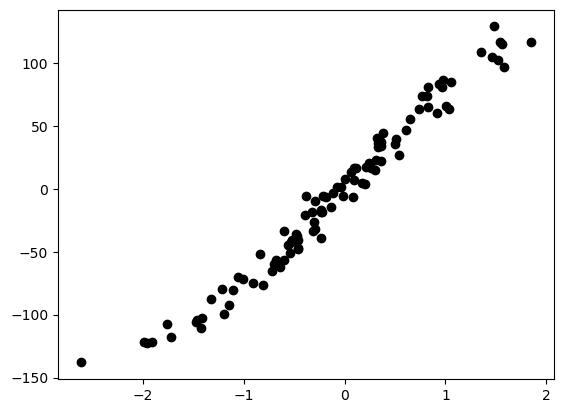

In [6]:
# plot the svr
plt.scatter(X, y, color='black')

plt.show()